In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import optuna
import wandb
import gc

import os
import sqlite3

gpus = tf.config.list_physical_devices('GPU')
    
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gc.collect()
tf.keras.backend.clear_session()

# Carga de los datos 

df = pd.read_csv("/Plant-Pathology-Classificator/plant-pathology-2020-/train.csv")

df["label"] = df[["healthy", "multiple_diseases", "rust", "scab"]].idxmax(axis=1)

df["filepath"] = df['image_id'].apply(lambda x: os.path.join("/Plant-Pathology-Classificator/plant-pathology-2020-/images", f'{x}.jpg'))


from sklearn.model_selection import train_test_split

X_train, X_temp = train_test_split(df, test_size = 0.5, stratify = df["label"], random_state = 4)

X_test, X_val = train_test_split(X_temp, test_size = 0.4, stratify = X_temp["label"], random_state = 4)

mini_train, _ = train_test_split(X_train, test_size = 0.6, stratify = X_train["label"], random_state = 4)

mini_val, _ = train_test_split(X_val, test_size = 0.2, stratify = X_val["label"], random_state = 4)

In [2]:
def color_saturation_filter(img):
    
    # Convertir a uint8
    if img.dtype == np.float32 and img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)

    # Convertir RGB a HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)

    # Rangos de matiz
    red_mask1 = (h < 10)
    red_mask2 = (h > 170)
    orange_yellow_mask = (h >= 10) & (h <= 30)
    green_mask = (h >= 35) & (h <= 85)
    cyan_blue_mask = (h >= 90) & (h <= 130)

    # Saturar rojo, naranja y amarillo
    s[red_mask1 | red_mask2 | orange_yellow_mask] *= 3.0

    # Disminuir tonos azules
    s[cyan_blue_mask] *= 0.7
    
    # Disminuir saturación del verde
    s[green_mask] *= 0.7   

    # Disminuir luminancia del verde
    v[green_mask] *= 0.85 

    # Recortar valores a [0,255]
    s = np.clip(s, 0, 255)
    v = np.clip(v, 0, 255)

    # Juntar y convertir en RGB
    hsv_mod = cv2.merge([h, s, v]).astype(np.uint8)
    rgb_mod = cv2.cvtColor(hsv_mod, cv2.COLOR_HSV2RGB)

    return rgb_mod.astype(np.float32)


In [3]:
def custom_preprocessing(img):
    
    img = color_saturation_filter(img)
    
    return img

In [4]:
datagen_train = ImageDataGenerator(
    preprocessing_function = custom_preprocessing,
    rescale = 1./255,
    rotation_range = 0.01 ,          
    width_shift_range = 0.02,      
    height_shift_range = 0.02,     
    shear_range = 0.2,            
    horizontal_flip = True,       
    vertical_flip = True,         
    brightness_range = (1.0, 1.12),
    channel_shift_range = 30.0,
    fill_mode = "nearest")

datagen_test_and_val = ImageDataGenerator(rescale = 1./255,
                                          preprocessing_function = custom_preprocessing,
                                          dtype = "float32")

In [5]:
mini_train_filter = datagen_train.flow_from_dataframe(
    dataframe = mini_train,
    x_col = "filepath",
    y_col = "label",
    target_size = (600,600),
    batch_size = 32,
    shuffle = True,
    seed = 4
)

mini_val_filter = datagen_test_and_val.flow_from_dataframe(
    dataframe = mini_val,
    x_col = "filepath",
    y_col = "label",
    target_size = (600,600),
    batch_size = 16,
    class_mode = "categorical",
    shuffle = False,
    seed = 4,
)

Found 364 validated image filenames belonging to 4 classes.
Found 292 validated image filenames belonging to 4 classes.


In [6]:
datagen_train2 = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 0.01 ,          
    width_shift_range = 0.02,      
    height_shift_range = 0.02,     
    shear_range = 0.2,            
    horizontal_flip = True,       
    vertical_flip = True,         
    brightness_range = (1.2, 1.5),
    channel_shift_range = 30.0,
    fill_mode = "nearest")

datagen_test_and_val2 = ImageDataGenerator(rescale = 1./255,
                                          dtype = "float32")

In [7]:
mini_train = datagen_train2.flow_from_dataframe(
    dataframe = mini_train,
    x_col = "filepath",
    y_col = "label",
    target_size = (600,600),
    batch_size = 32,
    shuffle = True,
    seed = 4
)

mini_val = datagen_test_and_val2.flow_from_dataframe(
    dataframe = mini_val,
    x_col = "filepath",
    y_col = "label",
    target_size = (600,600),
    batch_size = 16,
    class_mode = "categorical",
    shuffle = False,
    seed = 4,
)

Found 364 validated image filenames belonging to 4 classes.
Found 292 validated image filenames belonging to 4 classes.


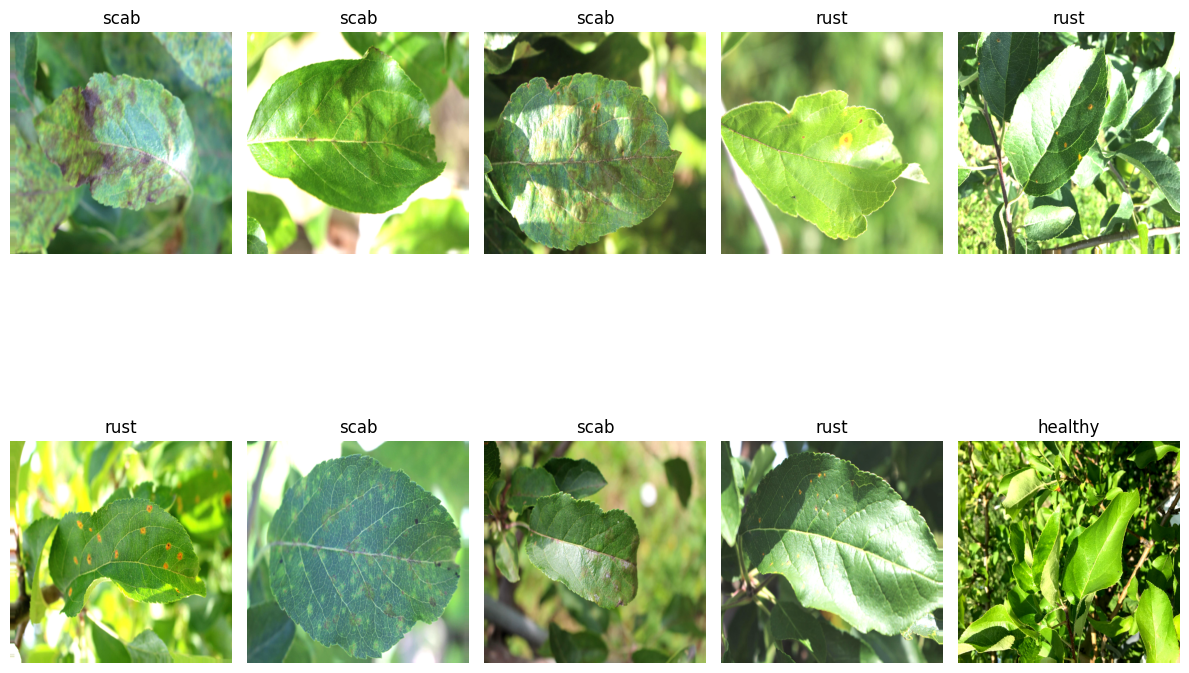

In [8]:
# Get one batch
img, labels = next(mini_train)

# Convert one-hot encoded labels to indices
label_indices = np.argmax(labels, axis=1)
class_names = list(mini_train.class_indices.keys())

# Display some images with titles
plt.figure(figsize=(12, 10))
for i in range(10):  # show first 8 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

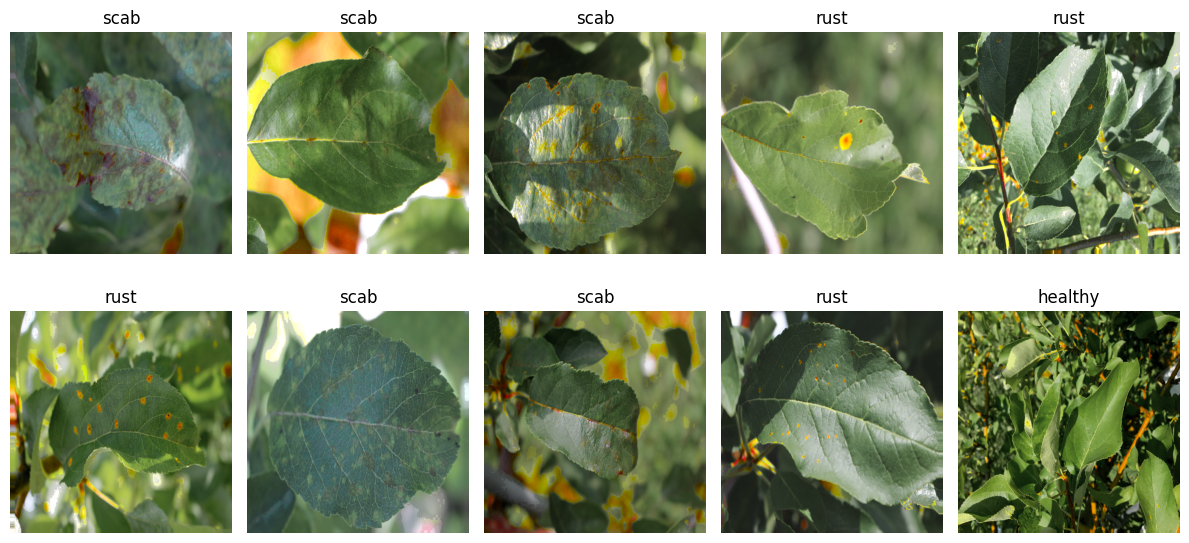

In [9]:
# Get one batch
img, labels = next(mini_train_filter)

# Convert one-hot encoded labels to indices
label_indices = np.argmax(labels, axis=1)
class_names = list(mini_train_filter.class_indices.keys())

# Display some images with titles
plt.figure(figsize=(12, 6))
for i in range(10):  # show first 8 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

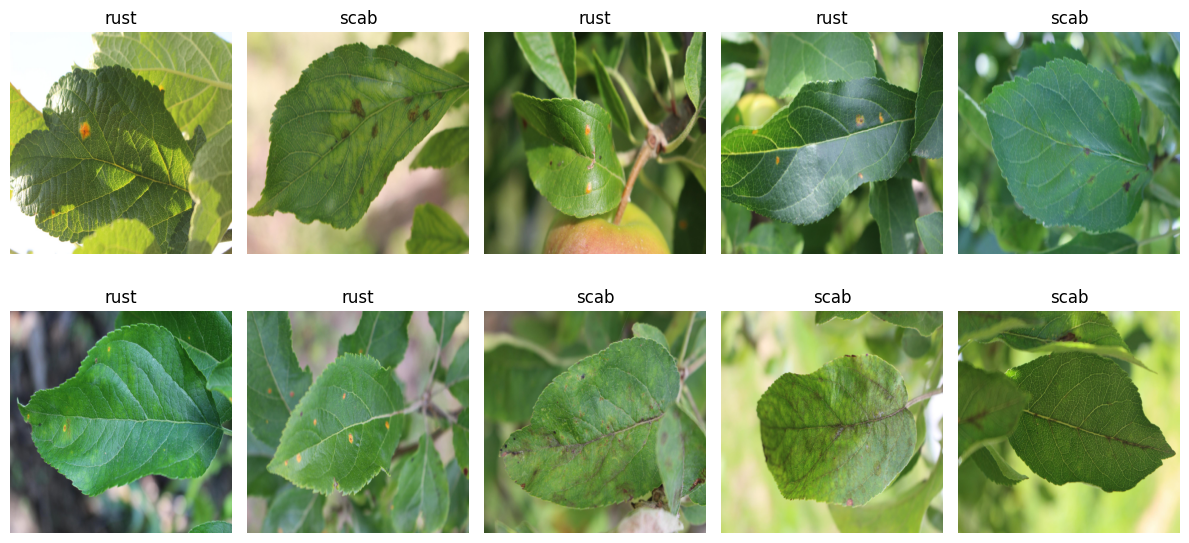

In [10]:
# Get one batch
img, labels = next(mini_val)

# Convert one-hot encoded labels to indices
label_indices = np.argmax(labels, axis=1)
class_names = list(mini_train.class_indices.keys())

# Display some images with titles
plt.figure(figsize=(12, 6))
for i in range(10):  # show first 8 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

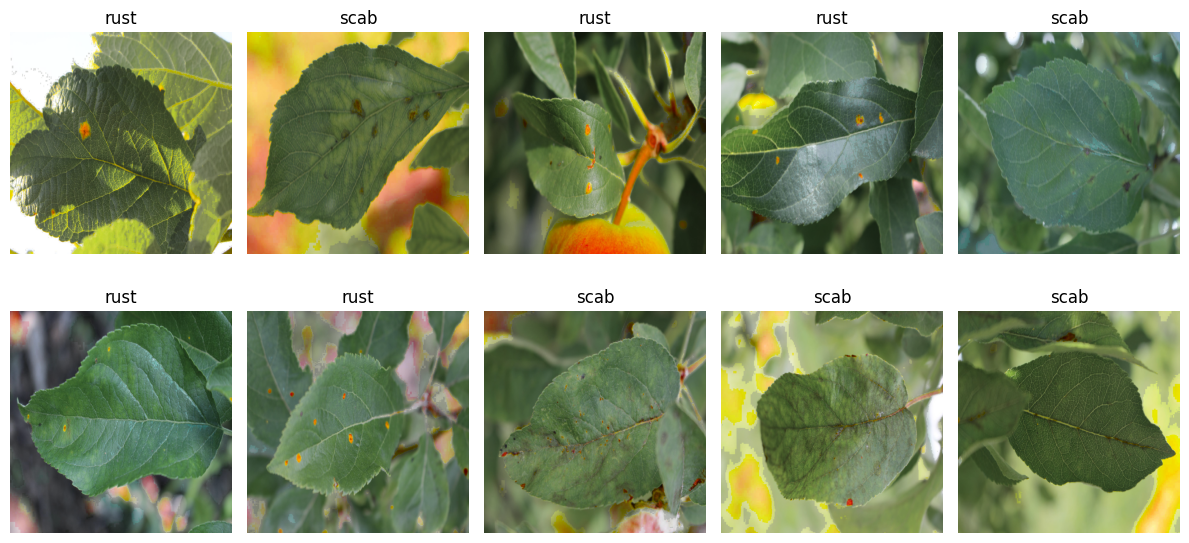

In [11]:
# Get one batch
img, labels = next(mini_val_filter)

# Convert one-hot encoded labels to indices
label_indices = np.argmax(labels, axis=1)
class_names = list(mini_train.class_indices.keys())

# Display some images with titles
plt.figure(figsize=(12, 6))
for i in range(10):  # show first 8 images
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()